    CS109A - Group 59: Zachary Himmelsbach and Alli Welton

## Revised Project Question: Can we predict a patient's HCI (hypometabolic convergence index) given their answers to a group of cognitive tests?

One of the indicators of Alzheimer's disease is hypometabolism (low levels of metabolic activity) in particular regions of the brain. Hypometabolism can be visualized in a PET scan of the brain using a radioactive glucose tracer, known as FDG-PET. However, an FDG-PET scan will usually cost a patient around $6700. Being able to predict the HCI from a set of cognitive test questions, and thus the likelihood that a patient with mild cognitive impairment will decline to Alzheimer's, could save money for patients and help alert families earlier. 

### Description of Data

#### What type of data are you dealing with?
*Response Variable* 

Our response variable will be the Hypometabolic Convergence Index, a measure developed by the Banner Alzheimer's Institute that indicates the degree to which a patient's FDG-PET brain scans correspond to those of a patient with an Alzheimer's diagnosis. In a 2011 paper, a team at BAI found that HCI was able to predict whether or not a patient with Mild Cognitive Impairment would develop Alzheimer's better than other biomarkers (hippocampal volume, amyloid and tau proteins in cerebral spinal fluid), memory test scores, and clinical assessments. 

The BAI team found that an 8.36 threshold value for the HCI (determined using a ROC curve) resulted in a 6.55 hazard ratio under the Cox Proportional Hazard Model(the meaning of the hazard ratio is that for every unit increase in HCI beyond that threshold, the chance of developing Alzheimer's increases by 6.55) (Chen et al, 57).

The dataset includes the HCI, date of exam, whether the exam was at 6, 12, 18, etc. months past a baseline visit, and patient ID. We originally had 2865 HCI measurements from 1420 patients, but after extracting ADNI 1 participants for whom we had cognitive test score information, we had 605 records remaining for 220 patients (218 from baseline visits, 203 from 6-month visits, and 184 from 12-month visits). 

*Predictors*

Under the ADNI 1 protocol, eight neuropsychological exams were administered, seven of which we have combined for predictive modeling of HCI. For each exam, we have the subject's scores at baseline, six months later, and 12 months later, matching the dates of the PET scans. (The original dataset includes additional testing at later dates, but relatively few participants have exam scores after the 12 month mark). The exams include sub-tasks testing patients' word recall, ability to follow instructions, memory, orientation (i.e. knowing who and where they are), and ability to perform daily tasks. Some of the tests must be administered by a medical professional directly to the patient, but others, like the Mini Mental-State Exam, can be given to the patient by anyone. One exam, the NPI, asks a caregiver about the patient's behavior. The dataset includes composite scores from each exam as well as sub-task (in some cases, item-level) scores. We excluded one exam due to high levels of missingness; similar items are present in the other tests. 







#### What methods have you used to explore the data?

We first considered using the Amyloid Convergence Index (a similar measurement developed by BAI that considers amyloid plaque build-up) or attempting to create a Tau Convergence Index (which would take the same approach as ACI or HCI, but instead looking at tau protein tangles) as response variables for which to build additional models. However, creating a TCI would have been more complicated than the scope of this project allows. The ACI data had not been computed for many patients in ADNI1 and did not have published documentation, so we decided to stick to attempting to predict the HCI alone. 

We noted that the BAI team found significant correlations between the HCI and scores on the ADAS, MMSE, AVLT,BNT, Animal/Vegetable-Naming, and Clock-Drawing tests (Chen et al, 56). However the BAI team did not attempt to parse out relationships between individual questions on these tests. In the EDA visualizations (see below), we also observed that the FAQ test and NPI test (which the BAI team did not test) appear to be linearly correlated with HCI.

In the neuropsychological test data, we explored which tests were administered under each ADNI protocol, selecting those which were included in ADNI 1. We tabulated how many unique patients had scores and sub-task scores for each exam, and noted that the number of records dropped for exams administered more than 12 months after baseline. For each of the seven exams we cleaned data and merged them together by patient ID, checking how many subjects had records for all tests. In preparation for feature selection (since we have many test items to choose from), we examined the correlations between items on the various tests.

### Visualizations

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
import time
import re
%matplotlib inline

In [2]:
#Set styles
sns.set_style('white')
sns.set_context('talk')

In [3]:
all_merged = pd.read_pickle("ADNIcsv/all_merged.pkl")
total_score_names = ['adas_total_0', 'adas_total_06', 'adas_total_12', 
                     'cdglobal_sc', 'cdglobal_06', 'cdglobal_12',  
                     'faqtotal_bl', 'faqtotal_06', 'faqtotal_12', 
                     'gdtotal_sc', 'gdtotal_12',  
                     'mmscore_sc', 'mmscore_06', 'mmscore_12', 
                     'hmscore',
                     'npiscore_bl', 'npiscore_06', 'npiscore_12']
hci_fields = ['hci_bl', 'hci_m06', 'hci_m12']
total_scores = all_merged.loc[:, total_score_names + hci_fields]

### HCI Exploration

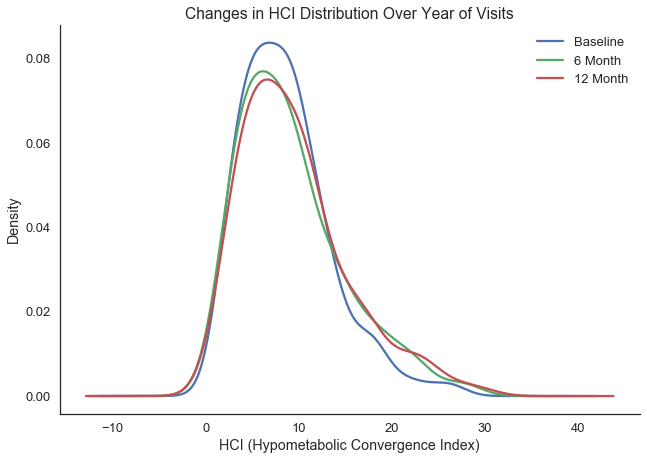

In [4]:
#Plot distribution of HCI scores changing over time
total_scores.hci_bl.plot.kde()
total_scores.hci_m06.plot.kde()
total_scores.hci_m12.plot.kde()
plt.title("Changes in HCI Distribution Over Year of Visits")
plt.xlabel("HCI (Hypometabolic Convergence Index)")
plt.legend(['Baseline', '6 Month', '12 Month'])
sns.despine()

In [5]:
total_scores.loc[:, ['hci_bl', 'hci_m06', 'hci_m12']].describe()

,hci_bl,hci_m06,hci_m12
count,218.000000,203.000000,184.000000
mean,8.639266,9.251281,9.562391
std,4.844950,5.676936,5.770063
min,1.230000,1.040000,1.310000
25%,5.162500,5.015000,5.277500
50%,7.980000,8.170000,8.385000
75%,10.977500,12.170000,11.895000
max,26.810000,28.360000,29.670000


In the data summary above, we observed that the mean and variation of HCI scores increased over time. In the plot, we see that the distributions broadened but the central peak did not shift noticeably. The shapes of the plots remained normally distributed, with perhaps a slight left skew, over time. 

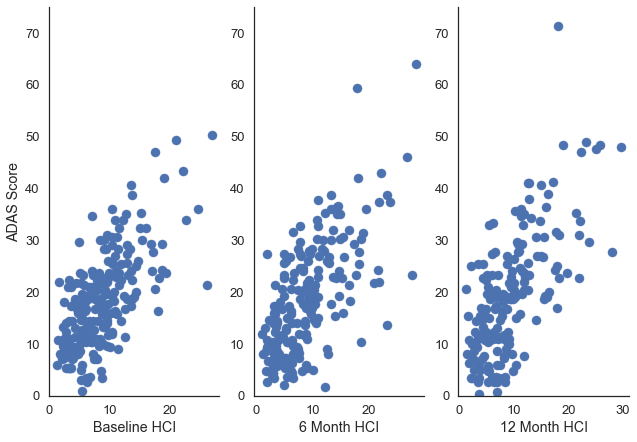

In [6]:
#Plot relationship between HCI and ADAS scores over Year of Visits
plt.subplot(1,3,1)
plt.ylim(0, 75)
plt.xlabel("Baseline HCI")
plt.ylabel("ADAS Score")
plt.scatter(total_scores.hci_bl, total_scores.adas_total_0)
plt.subplot(1,3,2)
plt.ylim(0, 75)
plt.xlabel("6 Month HCI")
plt.scatter(total_scores.hci_m06, total_scores.adas_total_06)
plt.subplot(1,3,3)
plt.ylim(0, 75)
plt.xlabel("12 Month HCI")
sns.despine()
plt.scatter(total_scores.hci_m12, total_scores.adas_total_12);

In the plots above, we observed a linear relationship between the HCI and ADAS scores. As time progressed, patient HCI scores tended to increase but the relationship with ADAS scores remained linear.

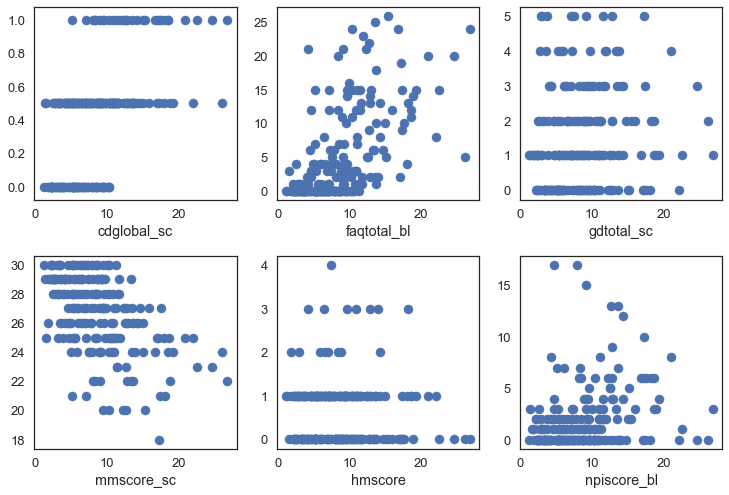

In [7]:
#Plot relationship of HCI to other tests at baseline
i = 1
for test in ['cdglobal_sc', 'faqtotal_bl', 'gdtotal_sc', 'mmscore_sc', 'hmscore', 'npiscore_bl']:
    plt.subplot(2,3,i)
    plt.scatter(total_scores.hci_bl, total_scores.loc[:, test])
    plt.xlabel(test)
    plt.tight_layout() 
    i += 1

In the subplots above, we observed clear linear trends for the FAQ, MM, and CD tests, with suggestions of a trend for the NPI score. The HM and GD tests did not seem to be obviously correlated. However, there may be individual items from these tests which add to the predictive power of our models.

## Correlations among exam items

In [13]:
# Function to plot correlations among exam items
def plot_test_corrs(test_prefix, test_full_name, note=''):
    items = [x for x in all_merged.columns if re.search(test_prefix, x) != None and re.search(r'06', x) != None]
    fig, ax = plt.subplots(1,1, figsize=(10,8))
    sns.heatmap(all_merged[items].dropna().corr(), ax=ax)
    ax.set_xticklabels(items, rotation='vertical')
    ax.set_yticklabels(items[::-1], rotation='horizontal')
    plt.title('Correlations Among ' + test_full_name + ' Items', fontsize=14)
    fig.text(.5, -.06, note, ha='center', fontsize=10)
    plt.show()

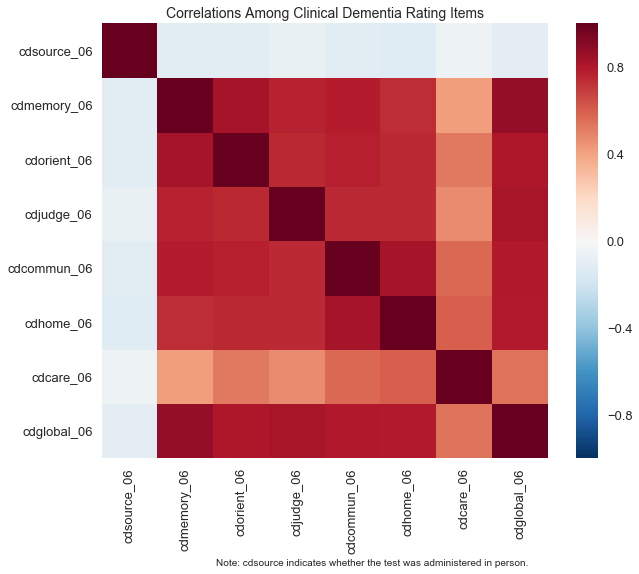

In [14]:
cd_name = 'Clinical Dementia Rating'
cd_note = 'Note: cdsource indicates whether the test was administered in person.'
plot_test_corrs('cd', cd_name, cd_note)

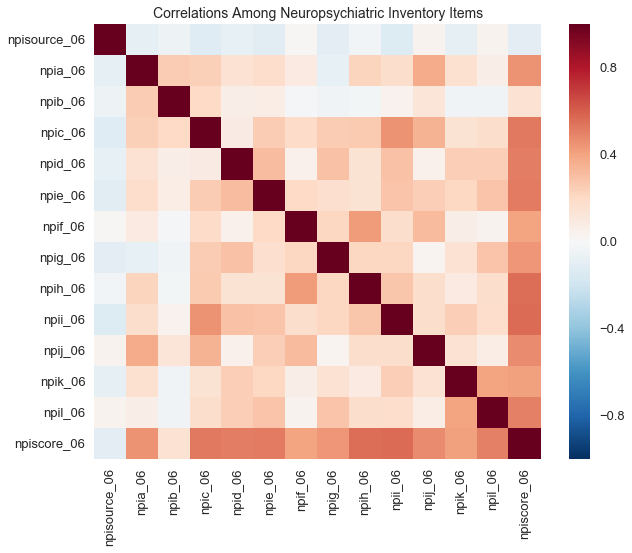

In [10]:
npi_name = 'Neuropsychiatric Inventory'
plot_test_corrs('npi', npi_name)

The above plots demonstrate that while some of the items are highly correlated, others are less predictive of one another. Some items are also less correlated with the total score on the exam, so some subset of items may predict HCI better than the overall scores.

## Revision of Project Question

We originally hoped to use cheap cognitive test data to predict information about some of the more expensive Alzheimer's diagnostic tools, such as PET and MRI scans. In the process of data exploration, we were able to settle on the HCI index as a meaningful and convenient response variable that would alleviate any need to process PET images ourselves. 

We saw an opportunity to contribute to existing work on the HCI because while the BAI team did consider the ADAS, MMSE, and CD assessments, they did not attempt to parse out which questions from the cognitive tests are most relevant for predicting HCI, nor did they consider the FAQ and NPI tests. Furthermore, our results may add robustness to those of the BAI team because they were constrained to a smaller sample of patients (~130) for whom the hippocampal volume was recorded.

#### References:
K. Chen, N. Ayutyanont, J. B. Langbaum, A. S. Fleisher, C. Reschke, W. Lee, X. Liu, D. Bandy, G. E. Alexander, P. M. Thompson, L. Shaw, J. Q. Trojanowski, C. R. Jack, Jr., S. M. Landau, N. L. Foster, D. J. Harvey, M. W. Weiner, R. A. Koeppe, W. J. Jagust, and E. M. Reiman, "Characterizing Alzheimer's disease using a hypometabolic convergence index," *Neuroimage.*, vol. 56, no. 1, pp. 52-60, May 2011.